In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import shap
import os


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer, PolynomialFeatures, MaxAbsScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingRegressor, StackingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, SelectFromModel
from xgboost import XGBClassifier,XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


import warnings
warnings.filterwarnings('ignore')



In [2]:
from rdkit import Chem,RDLogger, DataStructs
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, MACCSkeys, RDKFingerprint, rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem import Draw

try:
    from rdkit.Avalon import pyAvalonTools
    avalon_available = True
except ImportError:
    avalon_available = False

# Testing

In [3]:
data=pd.read_csv('train.csv')
data.head(10)

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3230,O=N(=O)c1cccc(c1)C(C)(C)C,275.15,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2906,CCCCCCCCCCCCCCCCCCCCC1CCCCC1,321.65,1,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2305,CCCOC(=O)CCC(=O)OCCC,267.25,2,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1133,c1ccc2c(c1)Sc3ccccc23,370.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2250,OCCOC(=O)C=C,213.00,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.shape

(2662, 427)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Columns: 427 entries, id to Group 424
dtypes: float64(1), int64(425), object(1)
memory usage: 8.7+ MB


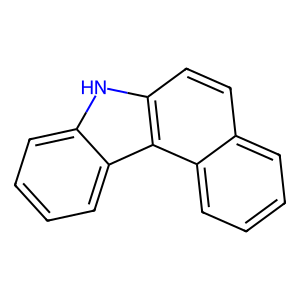

In [6]:
mol_smiles = data['SMILES'][1]
mol_object = Chem.MolFromSmiles(mol_smiles)
Descriptors.MolWt(mol_object)
Draw.MolToImage(mol_object)

In [7]:
mol1 = Chem.MolFromSmiles('CCO')   # Ethanol
mol2 = Chem.MolFromSmiles('CCN')   # Ethylamine

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

fp1 = morgan_gen.GetFingerprint(mol1)              #molecular fingerprints
fp2 = morgan_gen.GetFingerprint(mol2)

similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
print(similarity)

0.3333333333333333


In [8]:
mol1 = Chem.MolFromSmiles('CCO')   # Ethanol
mol2 = Chem.MolFromSmiles('CCN')   # Ethylamine

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fcfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024, atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen())
atom_gen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048)
rdk_gen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)

fp1 = [morgan_gen.GetFingerprint(mol1), atom_gen.GetFingerprint(mol1), rdk_gen.GetFingerprint(mol1),fcfp_gen.GetFingerprint(mol1)]
fp2=  [morgan_gen.GetFingerprint(mol2), atom_gen.GetFingerprint(mol2), rdk_gen.GetFingerprint(mol2),fcfp_gen.GetFingerprint(mol2)]

similarities = [DataStructs.TanimotoSimilarity(f1, f2) for f1, f2 in zip(fp1, fp2)]
names = ["Morgan", "AtomPair", "RDKit", "Feature Morgan"]
for n, s in zip(names, similarities):
    print(f"{n} similarity: {s:.3f}")

Morgan similarity: 0.333
AtomPair similarity: 0.200
RDKit similarity: 0.200
Feature Morgan similarity: 0.250


In [9]:
try1=pd.read_csv('BradleyDoublePlusGoodMeltingPointDataset.csv')
try1.head(10)

,key,name,smiles,mpC,csid,link,source,count,min,max,range
0,27956,cyclobutylmethane,C1(CCC1)C,-161.51,11232,http://pubs.acs.org/doi/abs/10.1021/ja01142a048,Lemaire HP; Livingston RL Journal of the Ameri...,2,-161.51,-161.50,0.01
1,16005,Nitrogen oxide,[O-][N+]#N,-90.80,923,http://msds.chem.ox.ac.uk/,academic website,2,-90.81,-90.80,0.01
2,16127,Sulfuryl difluoride,FS(F)(=O)=O,-135.80,16647,http://msds.chem.ox.ac.uk/,academic website,2,-135.82,-135.80,0.02
3,17138,disopyramide,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80,3002,http://dx.doi.org/10.1021/ci700307p,Hughes LD; Palmer DS; Nigsch F and Mitchell JB...,2,94.75,94.80,0.05
4,15628,Bromine,BrBr,-7.20,22817,http://msds.chem.ox.ac.uk/,academic website,2,-7.25,-7.20,0.05
5,16624,Lomefloxacin,O=C(O)C2=CN(CC)c1c(F)c(c(F)cc1C2=O)N3CC(C)NCC3,239.75,3811,http://www.drugbank.ca/drugs/DB00978,DrugBank,3,239.75,239.80,0.05
6,15962,"N,N-Dimethylmethanamine",CN(C)C,-117.00,1114,http://msds.chem.ox.ac.uk/,academic website,2,-117.08,-117.00,0.08
7,16135,Tetrachloromethane,ClC(Cl)(Cl)Cl,-23.00,5730,http://msds.chem.ox.ac.uk/,academic website,8,-23.00,-22.92,0.08
8,15862,Iodine,II,113.50,785,http://msds.chem.ox.ac.uk/,academic website,2,113.50,113.60,0.10
9,15571,Acetylene,C#C,-80.80,6086,http://msds.chem.ox.ac.uk/,academic website,2,-80.80,-80.70,0.10


In [10]:
try2=pd.read_csv('BradleyMeltingPointDataset.csv')
try2.head(10)

,key,name,smiles,mpC,csid,link,source,donotuse,donotusebecause
0,1,"2-(2,4-dinitrobenzyl)pyridine",c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,64018,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192,Alfa Aesar,NaN,NaN
1,2,2-(1-piperidinyl)aniline,c1ccc(c(c1)N)N2CCCCC2,46.0,403764,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073,Alfa Aesar,NaN,NaN
2,3,2-(1-piperazinyl)pyrimidine,c1cnc(nc1)N2CCNCC2,33.0,80080,http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884,Alfa Aesar,NaN,NaN
3,4,2-(1-piperazinyl)phenol,c1ccc(c(c1)N2CCNCC2)O,125.0,63701,http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252,Alfa Aesar,NaN,NaN
4,5,2-(1-cyclohexenyl)ethylamine,C1CCC(=CC1)CCN,-55.0,69388,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261,Alfa Aesar,NaN,NaN
5,6,2-(1-boc-4-piperidinyloxy)-n-methylacetamide,CC(C)(C)OC(=O)N1CCC(CC1)OCC(=O)NC,95.0,25027436,http://www.alfa.com/en/GP100W.pgm?DSSTK=H32990,Alfa Aesar,NaN,NaN
6,7,2-(1-boc-4-piperidinyloxy)-n-cyclopropylacetamide,CC(C)(C)OC(=O)N1CCC(CC1)OCC(=O)NC2CC2,86.0,25027435,http://www.alfa.com/en/GP100W.pgm?DSSTK=H32069,Alfa Aesar,NaN,NaN
7,8,"2-(1-boc-4-piperidinyloxy)-n,n-dimethylacetamide",CC(C)(C)OC(=O)N1CCC(CC1)OCC(=O)N(C)C,58.0,25027429,http://www.alfa.com/en/GP100W.pgm?DSSTK=H32708,Alfa Aesar,NaN,NaN
8,9,1-trimethylsilyl-1-propyne,CC#C[Si](C)(C)C,-69.0,72592,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24875,Alfa Aesar,NaN,NaN
9,10,1-tetralone,c1ccc2c(c1)CCCC2=O,7.0,10273,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13303,Alfa Aesar,NaN,NaN


#

In [11]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

brad_df=pd.read_csv('BradleyMeltingPointDataset.csv')
bradplus_df=pd.read_csv('BradleyMeltingPointDataset.csv')

In [12]:
print(test_df.shape)
print(train_df.shape)
print(brad_df.shape)
print(bradplus_df.shape)

(666, 426)
(2662, 427)
(28645, 9)
(28645, 9)


In [13]:
train_df=train_df[['SMILES','Tm']]
test_df=test_df[['id','SMILES']]

brad_df['Tm']=brad_df['mpC'].map(lambda x: x+273.15)
bradplus_df['Tm']=bradplus_df['mpC'].map(lambda x: x+273.15)

brad_df=brad_df[['smiles','Tm']]
bradplus_df=bradplus_df[['smiles','Tm']]

bradmerge_df=pd.concat((brad_df,bradplus_df),axis=0)
bradmerge_df=bradmerge_df.rename(columns={'smiles':'SMILES'})

merge_df=pd.concat((train_df,bradmerge_df),axis=0)

merge_df=merge_df.drop_duplicates(subset=['SMILES','Tm']).reset_index(drop=True)
print(f"Final training data shape : {merge_df.shape}")

Final training data shape : (29112, 2)


In [14]:
def safe_mol_from_smiles(s):
    try:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            return None
        Chem.SanitizeMol(mol)
        return mol
    except Exception:
        return None

In [15]:
RDLogger.DisableLog('rdApp.*')
merge_df['valid_mol'] = merge_df['SMILES'].apply(lambda s: safe_mol_from_smiles(s) is not None)
print(merge_df['valid_mol'].value_counts())

valid_mol
True     28838
False      274
Name: count, dtype: int64


In [16]:
merge_df = merge_df[merge_df['valid_mol']].loc[:, ['SMILES', 'Tm']].reset_index(drop=True)
merge_df.shape

(28838, 2)

In [17]:
def extract_all_descriptors(df,smiles_col):
    desc_list=Descriptors._descList
    result=[]
    for s in df[smiles_col]:
        mol=Chem.MolFromSmiles(s)
        if mol is None:
            row={name: None for name,func in desc_list}
        else:
            row={name:func(mol) for name, func in desc_list}
        result.append(row)
    df_desc=pd.DataFrame(result)
    return pd.concat((df,df_desc),axis=1)

def extract_all_fingerprints(df,smiles_col,morgan_radius=2, morgan_nbits=1024):
    fps_data=[]
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=morgan_radius, fpSize=morgan_nbits)
    fcfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=morgan_radius, fpSize=morgan_nbits, atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen())
    atom_gen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048)
    rdk_gen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)

    for smi in df[smiles_col]:
        mol=Chem.MolFromSmiles(smi)
        feature_rows={}
        if mol is not None:
            morgan_fp = morgan_gen.GetFingerprintAsNumPy(mol)
            fcfp_fp = fcfp_gen.GetFingerprintAsNumPy(mol)
            maccs_fp = MACCSkeys.GenMACCSKeys(mol)
            ap_fp = atom_gen.GetFingerprintAsNumPy(mol)
            rdk_fp = rdk_gen.GetFingerprintAsNumPy(mol)


            for i in range(morgan_nbits):feature_rows[f"Morgan_{i}"]=morgan_fp[i]
            for i in range(morgan_nbits): feature_rows[f"FCFP_{i}"] = fcfp_fp[i]
            for i in range(maccs_fp.GetNumBits()): feature_rows[f"MACCS_{i}"] = int(maccs_fp[i])
            for i in range(2048): feature_rows[f"AtomPair_{i}"] = ap_fp[i]
            for i in range(2048): feature_rows[f"RDKIT_{i}"] = rdk_fp[i]

            if avalon_available:
                avalon_fp = pyAvalonTools.GetAvalonFP(mol, nBits=1024)
                for i in range(1024): feature_rows[f"Avalon_{i}"] = int(avalon_fp[i])
        fps_data.append(feature_rows)

    fps_data=pd.DataFrame(fps_data)
    return pd.concat((df,fps_data),axis=1)

In [18]:
# merge_df=extract_all_descriptors(merge_df,'SMILES')
# test_df=extract_all_descriptors(test_df,'SMILES')

# merge_df=extract_all_fingerprints(merge_df,'SMILES')
# test_df=extract_all_fingerprints(test_df,'SMILES')


# merge_df=merge_df.dropna().reset_index(drop=True)
# test_df=test_df.fillna(0)

# print(f"final training features shape :{merge_df.shape}")
# print(f"final testing features shape : {test_df.shape}")

In [19]:
# merge_df.to_csv('merge_df.csv',index=False)
# test_df.to_csv('test_df.csv',index=False)

In [28]:
merge_df=pd.read_csv('merge_df.csv')
test_df=pd.read_csv('test_df.csv')

print(f"final training features shape :{merge_df.shape}")
print(f"final testing features shape : {test_df.shape}")

final training features shape :(28809, 7554)
final testing features shape : (666, 7554)


In [29]:
merge_df.head(10)

,SMILES,Tm,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,Avalon_1014,Avalon_1015,Avalon_1016,Avalon_1017,Avalon_1018,Avalon_1019,Avalon_1020,Avalon_1021,Avalon_1022,Avalon_1023
0,FC1=C(F)C(F)(F)C1(F)F,213.15,11.537037,11.537037,2.668981,-4.947338,0.479530,28.200000,162.032,162.032,...,0,0,0,0,0,0,1,0,0,0
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,3.470111,3.470111,1.207271,1.207271,0.446879,11.529412,217.271,206.183,...,1,0,0,0,0,0,0,0,0,0
2,CCN1C(C)=Nc2ccccc12,324.15,4.446898,4.446898,0.992407,0.992407,0.625839,10.833333,160.220,148.124,...,0,0,1,0,0,1,0,0,1,1
3,CC#CC(=O)O,351.15,9.425694,9.425694,1.071759,-1.071759,0.422302,5.500000,84.074,80.042,...,0,0,0,0,0,0,0,0,0,0
4,CCCCC(S)C,126.15,4.232083,4.232083,0.597176,0.597176,0.540734,14.142857,118.245,104.133,...,0,0,0,0,0,0,0,0,0,0
5,O=N(=O)c1cccc(c1)C(C)(C)C,275.15,10.485659,10.485659,0.035694,-0.365833,0.491065,11.307692,179.219,166.115,...,0,0,0,1,0,0,0,0,0,0
6,CCCCCCCCCCCCCCCCCCCCC1CCCCC1,321.65,2.304418,2.304418,1.101674,1.101674,0.199903,15.576923,364.702,312.286,...,0,0,0,0,0,0,0,0,0,0
7,CCCOC(=O)CCC(=O)OCCC,267.25,10.950189,10.950189,0.113639,-0.333057,0.589176,9.571429,202.250,184.106,...,0,0,0,0,0,0,0,0,1,0
8,c1ccc2c(c1)Sc3ccccc23,370.15,2.188657,2.188657,1.377870,1.377870,0.494058,11.076923,184.263,176.199,...,1,0,0,0,0,0,0,0,0,0
9,OCCOC(=O)C=C,213.00,10.119306,10.119306,0.046481,-0.500880,0.406762,8.125000,116.116,108.052,...,0,0,0,1,0,0,0,0,0,0


In [30]:
test_df.head(10)

,id,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,Avalon_1014,Avalon_1015,Avalon_1016,Avalon_1017,Avalon_1018,Avalon_1019,Avalon_1020,Avalon_1021,Avalon_1022,Avalon_1023
0,1022,CCOC(=O)c1ccc(O)cc1,11.052121,11.052121,0.141712,-0.363426,0.678102,9.416667,166.176,156.096,...,0,0,0,0,0,0,0,0,0,0
1,1146,CCCCCCc1ccc(O)cc1O,9.487875,9.487875,0.124822,0.124822,0.706408,10.357143,194.274,176.130,...,0,0,0,0,1,0,0,0,0,0
2,79,ClCBr,4.915123,4.915123,0.534722,0.534722,0.435708,6.000000,129.384,127.368,...,0,0,0,1,0,0,0,0,0,0
3,2279,C=CCCCCCCCC,3.694652,3.694652,1.200521,1.200521,0.371151,9.700000,140.270,120.110,...,0,0,0,1,0,0,0,0,0,0
4,1342,Fc1ccc(cc1)C(F)(F)F,12.107500,12.107500,0.668519,-4.381250,0.516949,11.636364,164.101,160.069,...,0,0,0,0,0,0,1,0,0,0
5,2082,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,2.304925,2.304925,1.374362,1.374362,0.124753,11.379310,408.799,348.319,...,0,0,0,0,0,0,0,0,0,0
6,29,CCCC(=O)OCC(COC(=O)CCC)OC(=O)CCC,11.491059,11.491059,0.089591,-0.744757,0.430513,10.285714,302.367,276.159,...,0,0,0,0,0,0,0,0,1,0
7,515,O=C(Cl)c1cccc(c1)C(=O)Cl,10.631241,10.631241,0.266821,-0.602068,0.691354,9.500000,203.024,198.992,...,0,0,0,0,0,0,0,0,0,0
8,2309,CCCCCC(=O)CCCCC,11.192693,11.192693,0.469352,0.469352,0.507358,10.166667,170.296,148.120,...,0,0,0,0,0,0,0,0,1,0
9,1177,CCOC(=O)CC(=O)C,10.410417,10.410417,0.103333,-0.439815,0.413109,8.666667,130.143,120.063,...,0,0,0,0,0,0,0,0,1,0


In [31]:
x_train=merge_df.drop(labels=['SMILES','Tm'],axis=1)
y_train=merge_df['Tm']
x_test=test_df.drop(labels=['SMILES','id'],axis=1)


train_col=x_train.columns
test_col=x_test.columns
shared_col=list(set(train_col) & set(test_col))
x_train=x_train[shared_col]
x_test=x_test[shared_col]

In [32]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback

import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone


In [33]:
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# import optuna
# from optuna.samplers import TPESampler
# from optuna.pruners import MedianPruner
# from optuna.integration import XGBoostPruningCallback
# from sklearn.preprocessing import PowerTransformer
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import mean_absolute_error


# random_state = 42
# storage = "sqlite:///optuna_melting.db"
# n_trials = 80
# CV_folds = 10
# early_stopping = 200
# num_boost_round = 5000

# selector_model_params = dict(
#     n_estimators = 500,
#     max_depth = 6,
#     learning_rate = 0.05,
#     random_state = random_state,
#     tree_method = 'gpu_hist', 
#     verbosity = 0
# )


# def cv_split_for_regression(y, n_splits=CV_folds, random_state=random_state):
#     q = min(10, max(2, n_splits))
#     y_binned = pd.qcut(y, q=q, labels=False, duplicates='drop')
#     return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(np.zeros(len(y)), y_binned)


# def colvec(a):
#     arr = np.asarray(a)
#     if arr.ndim == 1:
#         return arr.reshape(-1, 1)
#     if arr.ndim == 2 and arr.shape[1] == 1:
#         return arr
#     return arr.ravel().reshape(-1, 1)


# def build_xgb_params(trial, prefer_gpu=True):
#     params = {
#         'objective': 'reg:squarederror',
#         'eval_metric': 'mae',
#         'verbosity': 0,

#         'max_depth': trial.suggest_int('max_depth', 2, 8),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
#         'gamma': trial.suggest_float('gamma', 1e-4, 5.0, log=True),
#         'lambda': trial.suggest_float('lambda', 1e-3, 50.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-4, 10.0, log=True),
#     }

#     if prefer_gpu:
#         params['tree_method'] = 'gpu_hist'
#     else:
#         params['tree_method'] = 'hist'
#     return params

# def objective(trial, X, y, X_test=None, prefer_gpu=True):
#     params = build_xgb_params(trial, prefer_gpu=prefer_gpu)
#     fold_maes = []
#     test_preds = [] if X_test is not None else None

#     try:
#         for fold_idx, (train_idx, val_idx) in enumerate(cv_split_for_regression(y, n_splits=CV_folds)):
#             X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#             y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
#             yeo = PowerTransformer(method='yeo-johnson')
#             y_train_t = yeo.fit_transform(colvec(y_train)).squeeze()
#             y_val_t = yeo.transform(colvec(y_val)).squeeze()


#             sel_params = dict(selector_model_params)
#             sel_params['tree_method'] = sel_params.get('tree_method', params.get('tree_method', 'hist'))
#             selector_model = xgb.XGBRegressor(**{k:v for k,v in sel_params.items() if k != 'verbosity'}, verbosity=sel_params.get('verbosity', 0))

#             try:
#                 selector_model.fit(X_train, y_train_t)
#             except xgb.core.XGBoostError as e:
#                 if 'GPU' in str(e) or 'gpu' in str(e).lower():
#                     selector_model.set_params(tree_method='hist')
#                     selector_model.fit(X_train, y_train_t)
#                 else:
#                     raise

#             selector = SelectFromModel(selector_model, prefit=True, threshold="mean")
#             selected_cols = X_train.columns[selector.get_support()]
#             if len(selected_cols) == 0:
#                 selected_cols = X_train.columns

#             X_train_sel = X_train[selected_cols]
#             X_val_sel = X_val[selected_cols]
#             if X_test is not None:
#                 X_test_sel = X_test[selected_cols]

#             dtrain = xgb.DMatrix(X_train_sel, label=y_train_t)
#             dval = xgb.DMatrix(X_val_sel, label=y_val_t)
#             watchlist = [(dtrain, 'train'), (dval, 'valid')]

#             pruning_callback = XGBoostPruningCallback(trial, "valid-mae")

#             try:
#                 bst = xgb.train(
#                     params=params,
#                     dtrain=dtrain,
#                     num_boost_round=num_boost_round,
#                     evals=watchlist,
#                     early_stopping_rounds=early_stopping,
#                     callbacks=[pruning_callback],
#                     verbose_eval=False
#                 )
#             except xgb.core.XGBoostError as e:
#                 if 'GPU' in str(e) or 'gpu' in str(e).lower():
#                     params_cpu = dict(params)
#                     params_cpu['tree_method'] = 'hist'
#                     bst = xgb.train(
#                         params=params_cpu,
#                         dtrain=dtrain,
#                         num_boost_round=num_boost_round,
#                         evals=watchlist,
#                         early_stopping_rounds=early_stopping,
#                         callbacks=[pruning_callback],
#                         verbose_eval=False
#                     )
#                 else:
#                     raise

#             # 4) predict and inverse-transform
#             y_val_pred_t = bst.predict(dval, ntree_limit=getattr(bst, 'best_ntree_limit', None))
#             y_val_pred = yeo.inverse_transform(colvec(y_val_pred_t)).squeeze()
#             fold_mae = mean_absolute_error(y_val, y_val_pred)
#             fold_maes.append(fold_mae)

#             # test preds per fold (optional)
#             if X_test is not None:
#                 dtest = xgb.DMatrix(X_test_sel)
#                 y_test_pred_t = bst.predict(dtest, ntree_limit=getattr(bst, 'best_ntree_limit', None))
#                 y_test_pred = yeo.inverse_transform(colvec(y_test_pred_t)).squeeze()
#                 test_preds.append(y_test_pred)

#             # report to Optuna
#             trial.report(np.mean(fold_maes), step=fold_idx)
#             if trial.should_prune():
#                 raise optuna.TrialPruned()

#         return float(np.mean(fold_maes))

#     except optuna.TrialPruned:
#         raise
#     except Exception as e:

#         print(f"Trial failed with exception: {e}")
#         return float('inf')

# # ---------- create and run study ----------
# sampler = TPESampler(seed=random_state)
# pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=1)
# study = optuna.create_study(
#     study_name="melting_point_xgb",
#     direction="minimize",
#     sampler=sampler,
#     pruner=pruner,
#     storage=storage,
#     load_if_exists=True
# )

# study.optimize(lambda trial: objective(trial, x_train, y_train, X_test=x_test, prefer_gpu=True),
#                n_trials=n_trials, show_progress_bar=True)

# print("Best MAE:", study.best_value)
# print("Best params:", study.best_params)
# best_params = dict(study.best_params)
# best_params.update({'objective': 'reg:squarederror', 'eval_metric': 'mae', 'verbosity': 0})


In [34]:
import xgboost

best_params = {
    'objective': 'reg:squarederror', 
    'max_depth': 3, 
    'learning_rate': 0.0168, 
    'min_child_weight': 5, 
    'subsample': 0.894, 
    'colsample_bytree': 0.590, 
    'gamma': 0.0113, 
    'lambda': 4.445, 
    'alpha': 0.129,
    'eval_metric': 'mae',
    'tree_method': 'hist' # Use GPU for speed
}

skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2025)
yeo = PowerTransformer(method='yeo-johnson')

oof_val = np.zeros(len(x_train))
test_pred = []
final_val_scores = []
X = x_train.copy()   # full features
Y = y_train.copy()   # full target

for i, (train_index, val_index) in enumerate(skfold.split(X, pd.qcut(Y, q=10, labels=False, duplicates='drop'))):
    print(f"===== Fold {i+1} =====")
    
    # Split data correctly
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

    # Transform target variable
    Y_train_transformed = yeo.fit_transform(Y_train.values.reshape(-1, 1)).squeeze()
    Y_val_transformed = yeo.transform(Y_val.values.reshape(-1, 1)).squeeze()

    # Feature Selection inside the fold
    selector_model = xgboost.XGBRegressor(
        n_estimators=500, max_depth=6, learning_rate=0.05, 
        random_state=2025, tree_method='gpu_hist', verbosity=0
    )
    selector_model.fit(X_train, Y_train_transformed)
    selector = SelectFromModel(selector_model, prefit=True, threshold="mean")
    selected_features = X_train.columns[selector.get_support()]
    print(f"Selected {len(selected_features)} features for this fold.")

    # Apply feature selection
    X_train_new = X_train[selected_features]
    X_val_new = X_val[selected_features]
    X_test_new = x_test[selected_features]

    # DMatrix
    dtrain = xgboost.DMatrix(X_train_new, label=Y_train_transformed)
    dval = xgboost.DMatrix(X_val_new, label=Y_val_transformed)
    dtest = xgboost.DMatrix(X_test_new)

    # Train model
    model = xgboost.train(
        params=best_params, 
        dtrain=dtrain, 
        num_boost_round=15000, 
        evals=[(dtrain, 'train'), (dval, 'valid')],
        early_stopping_rounds=300,
        verbose_eval=1000
    )

    # Predictions
    y_val_predict_transformed = model.predict(dval)
    y_test_predict_transformed = model.predict(dtest)

    y_val_predict = yeo.inverse_transform(y_val_predict_transformed.reshape(-1, 1)).squeeze()
    y_test_predict = yeo.inverse_transform(y_test_predict_transformed.reshape(-1, 1)).squeeze()

    # Store results
    oof_val[val_index] = y_val_predict
    test_pred.append(y_test_predict)

    fold_mae = mean_absolute_error(Y_val, y_val_predict)
    final_val_scores.append(fold_mae)
    print(f'Fold {i+1} MAE: {fold_mae}\n')

print(f'\nAverage Validation MAE across all folds: {np.mean(final_val_scores)}')

===== Fold 1 =====
Selected 1579 features for this fold.
[0]	train-mae:0.79440	valid-mae:0.79165
[1000]	train-mae:0.29998	valid-mae:0.30644
[2000]	train-mae:0.27146	valid-mae:0.28552
[3000]	train-mae:0.25360	valid-mae:0.27364
[4000]	train-mae:0.24039	valid-mae:0.26530
[5000]	train-mae:0.22989	valid-mae:0.25894
[6000]	train-mae:0.22102	valid-mae:0.25361
[7000]	train-mae:0.21336	valid-mae:0.24912
[8000]	train-mae:0.20685	valid-mae:0.24537
[9000]	train-mae:0.20094	valid-mae:0.24222
[10000]	train-mae:0.19568	valid-mae:0.23963
[11000]	train-mae:0.19078	valid-mae:0.23734
[12000]	train-mae:0.18607	valid-mae:0.23546
[13000]	train-mae:0.18188	valid-mae:0.23367
[14000]	train-mae:0.17805	valid-mae:0.23211
[14999]	train-mae:0.17449	valid-mae:0.23076
Fold 1 MAE: 22.530005273365468

===== Fold 2 =====
Selected 1635 features for this fold.
[0]	train-mae:0.79449	valid-mae:0.79786
[1000]	train-mae:0.29970	valid-mae:0.31273
[2000]	train-mae:0.27142	valid-mae:0.29212
[3000]	train-mae:0.25299	valid-mae:0.

In [35]:
final_pred=np.mean(test_pred,axis=0)

sub=pd.DataFrame({
    "id":test_df["id"],
    "Tm":final_pred
})

sub.to_csv("sub-2.csv",index=False)